In [1]:
# Notebook for demultiplexing protocol version: 7.0
# Author: Jason Qian
# Date: 250518

# Import Libraries

In [1]:
import sys
import os
import glob
import pandas as pd
import numpy as np
import re
import time
import textwrap
from Bio import SeqIO
from Bio import pairwise2
import datetime
from datetime import date; date_time_str=date.today().strftime('%Y%m%d')[2:]; print(f'Today: {date_time_str}\n')
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import display
from statsmodels.distributions.empirical_distribution import ECDF
import math

## Import custom functions to sequencing reads analysis
sys.path.append('/home/jq01/scripts')
import wetlab_util_jq 

# Showing all entire cells in dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload 
wetlab_util_jq.check_ont_software_reqs() # showing the path of programs used for the sequencing reads processing

/home/jq01/.conda/envs/jq-pyrosetta/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Today: 250601

Dorado path: /software/lab/ont/dorado/dorado-0.8.0-linux-x64/bin/dorado
Samtools path: /software/lab/ont/samtools/samtools-1.21/samtools
Chopper path: /software/lab/ont/chopper/v0.9/chopper
Nanoq path: /software/lab/ont/nanoq/nanoq-0.10.0-x86_64-unknown-linux-musl/nanoq
Minimap2 path: /software/lab/ont/minimap2/minimap2-2.28_x64-linux/minimap2
Apptainer path where cutadapt is installed: /mnt/net/software/containers/users/jq01/spec/demuxing_w_conda.sif 



# Set Global Directories

In [2]:
'''
Define global directories from user provided inputs
'''
transfer_file_start_date = "250520"    # input date of demultiplexing experiment
library_name = "NH20_subpool2"                  # custom name of experiment

working_dir = f'/home/jq01/wetlab/sequencing/nanopore/{transfer_file_start_date}_{library_name}/' # Folder where demuxing experiment files are stored
os.makedirs(f'{working_dir}',exist_ok=True)

'''
Define echo transfer directory
'''
echo_dir = f'{working_dir}{transfer_file_start_date}_echo_transfer/'                        # Folder where echo transfer files are output
os.makedirs(f'{echo_dir}',exist_ok=True)
print(f'Echo transfer directory: {echo_dir}')

Echo transfer directory: /home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250520_echo_transfer/


# Generating Echo Transfer Files

### 0. Culture transfer

In [ ]:
# Generating echo file to compress cultures from 384 to 1536-well plates

In [ ]:
# Generate instructions source plate and well to destination plate and well and volume

# Define how many 384 culture plates and 1536-well destination plates
no_source_plates = 20  # 384-well culture plates
transfer_volume = 2000.0 # volume (nl) of culture to transfer from 384 -> 1536-well plates. Unit is in nanoliters because echo works in this unit, so volume = 1000 x number of ul 

# General function to generate well names (e.g., A1, B2, etc.) for 96, 384, or 1536-well plates.
# input options:  "96w_plate", "384w_plate", "1536w_plate"
source_wells_384 = wetlab_util_jq.generate_well_names('384w_plate') # for 384-well plate
dest_wells_1536  = wetlab_util_jq.generate_well_names('1536w_plate') # for 1536-well plate

# Calculate total source wells and required destination plates
total_source_wells = no_source_plates * len(source_wells_384)
no_dest_plates = math.ceil(total_source_wells / len(dest_wells_1536))  # 1536-well destination plates

echo_instructions = []
dest_counter = 0
dest_p_no = 1
dest_p = f"dest_1536_{dest_p_no:02d}"

# loop over source plates number
for source_p_no in range(1, no_source_plates+1):
    source_p = f"source_384_{source_p_no:02d}"
    
    # loop over source well number
    for source_idx, source_w in enumerate(source_wells_384):
        if dest_counter == 1536:       # we are one index about plate size
            dest_counter = 0
            dest_p_no += 1
        
        dest_p = f"dest_1536_{dest_p_no:02d}"   # destination plate formatting with 2 decimal integers "dest_1536_05"
        dest_w = dest_wells_1536[dest_counter]  # destination well 
        
        if source_idx == 0:
            print(source_p, source_w,  "--->", dest_p, dest_w )
            
        echo_instructions.append([source_p, source_w, dest_p, dest_w, transfer_volume])
        dest_counter += 1

assert len(echo_instructions) == total_source_wells, "Mismatch in total source wells."
assert len(echo_instructions) <= no_dest_plates * 1536, "Exceeded available destination wells."
print("Assertion passed. The number of rows in echo instructions is correct.")
print(f"Generated {len(echo_instructions)} transfers across {no_dest_plates} destination plates.")


source_384_01 A1 ---> dest_1536_01 A1
source_384_02 A1 ---> dest_1536_01 I1
source_384_03 A1 ---> dest_1536_01 Q1
source_384_04 A1 ---> dest_1536_01 Y1
source_384_05 A1 ---> dest_1536_02 A1
source_384_06 A1 ---> dest_1536_02 I1
source_384_07 A1 ---> dest_1536_02 Q1
source_384_08 A1 ---> dest_1536_02 Y1
source_384_09 A1 ---> dest_1536_03 A1
source_384_10 A1 ---> dest_1536_03 I1
source_384_11 A1 ---> dest_1536_03 Q1
source_384_12 A1 ---> dest_1536_03 Y1
source_384_13 A1 ---> dest_1536_04 A1
source_384_14 A1 ---> dest_1536_04 I1
source_384_15 A1 ---> dest_1536_04 Q1
source_384_16 A1 ---> dest_1536_04 Y1
source_384_17 A1 ---> dest_1536_05 A1
source_384_18 A1 ---> dest_1536_05 I1
source_384_19 A1 ---> dest_1536_05 Q1
source_384_20 A1 ---> dest_1536_05 Y1
Assertion passed. The number of rows in echo instructions is correct.
Generated 7680 transfers across 5 destination plates.


In [ ]:
# Export culture transfer csv file into echo directory
write = False

file_name = date_time_str + "_step0_culture_transfer" + ".csv"
output_file = os.path.join(echo_dir, file_name)  # output directory and file_name

if write:
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Source Plate Name",
                        "Source Well",
                        "Destination Plate Name"
                        ,"Destination Well",
                        "Transfer Volume"]) # Column name needs this format for Echo compatibility
        
        for instr in echo_instructions:
            writer.writerow(instr)
        print(f'Culture transfer echo csv file is saved as: \n{echo_dir}{file_name} \n')

Culture transfer echo csv file is saved as: 
/home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250520_echo_transfer/250520_step0_culture_transfer.csv 



### 1. Barcode transfer

In [ ]:
# Generating echo file to transfer daisy chain barcode combinations from source 384-well barcode plate to destination 1536-well plates

In [ ]:
# User inputs. These variable can be adjusted based on experiments

# Remember that ech 384-well plate has a working volume of 20 - 65 ul!! So the dilution factor need to be within these volumes
dilution_factor = 9  # Example, a dilution factor of 6 means 10 ul from stock bc + 50 ul of H20. 
mimimum_bc_conc = 120.0   # default mimimum barcode concentration (ng/ul)
dna_per_bc = 2     # barcode (nanograms) to transfer to each well
max_vol = 1000     # maximum barcode volume (nanoliters) + water to transfer to each well

# Barcode exclusion list based on bad performance. Add any other barcodes you want to exclude. When using group 3 barcodes, always exlude:
# 1_2, 1_8, 1_11, 1_13, 1_14, 1_15, 1_20, 1_26. 
exclusion_list = ['1_2',
                  '1_8',
                  '1_11',
                  '1_13',
                  '1_14',
                  '1_15',
                  '1_20',
                  '1_26',
                  '1_24', 
                  '2_12', 
                  '2_31', 
                  '3_32']

In [ ]:
# Map barcodes to well positions in a 384-well plate as a source plate for echo transfer

no_bc_groups = 3      # number of barcode groups (BC1, BC2, BC3, BC4)
bc_per_group = 32     # number of barcodes per group 

barcode_to_well_384 = wetlab_util_jq.map_barcodes_to_wells(no_bc_groups, bc_per_group)  # output is dictionary (key = barcode name and value = well position)

# check dictionary is correct
print(dict(list(barcode_to_well_384.items())[:5]))  # key : barcode name, value : one bc from each of bc_groups


{'1_1': 'A1', '1_2': 'A3', '1_3': 'A5', '1_4': 'A7', '1_5': 'A9'}


In [ ]:
# Generate well names (e.g., A1, B2, etc.) for 96, 384, or 1536-well plate formats
# Input:  "96w_plate", "384w_plate", "1536w_plate"

w96 = wetlab_util_jq.generate_well_names('96w_plate')  # well names for a single 96-well plate
w96_multi = [str(plate)+ '_' + well for plate in range(1, 20) for well in w96] # well names for twenty 96-well plates

w384 = wetlab_util_jq.generate_well_names('384w_plate') # well names for a single 384-well plate
w384_multi = [str(plate)+ '_' + well for plate in range(1, 20) for well in w384] # well names for twenty 384-well plates

w1536 = wetlab_util_jq.generate_well_names('1536w_plate') # well names for a single 1536-well plate
w1536_multi = [str(plate)+ '_' + well for plate in range(1, 20) for well in w1536] # well names for twenty 1536-well plates

In [ ]:
# Reformat dataframe and dilution of stock barcode miniprep plate 

bc_csv_path = "/net/expdata/Users/Baker_Lab/jasonqian/nanodrop/2024/240808_96_dmx_group3_barcode.txt" # path of BC nanodrop concentration file
!ls {bc_csv_path} # check if the BC nanodrop concentration file is present
mini_df = pd.read_csv(bc_csv_path, sep="\t", on_bad_lines="skip" ) # load nanoedrop file as mini_df dataframe

mini_df = mini_df.set_index('Well ', drop=False).reindex(w96)   # reindex the mini_df with well order as w96: A1, A2 etc instead of A1, B2..
mini_df['Source Well'] = w384[0:192:2]    # Add a column called Source Well and matches 96w plate wells to 382w plate wells
mini_df['concentration'] = mini_df['Conc. '] / dilution_factor # New concentration of BC plate. Dilute the entire barcode stock plate by dilution_factor set earlier

# "well_to_barcode" uses dictionary comprehension to reverse the key-value pairs of the barcode_to_well_384 dictionary
# barcode_to_well_384: keys = barcodes and values = well positions in a 384-well plate
# well_to_barcode_384: keys = well positions and the values = the barcodes in a 384-well plate
well_to_barcode_384 = {value:key for key,value in barcode_to_well_384.items()}  
mini_df['bc'] = mini_df['Source Well'].map(well_to_barcode_384)

#mini_df.loc['A5',:]   # optional check: selects the row with the index label 'A3' and returns all values for that row

/net/expdata/Users/Baker_Lab/jasonqian/nanodrop/2024/240808_96_dmx_group3_barcode.txt


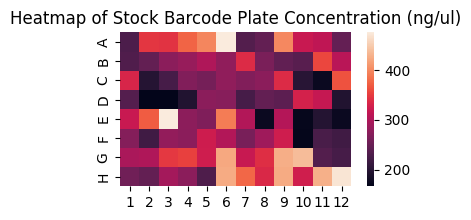

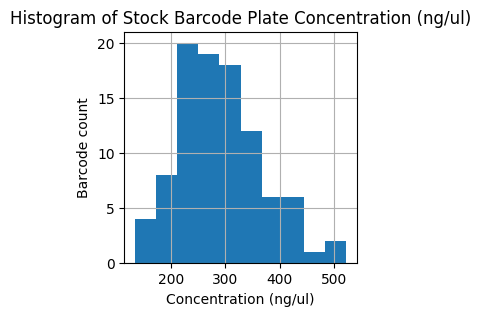

In [ ]:
# Visualize concentration of stock barcode miniprep plate measured from nanodrop

# Create a heatmap of BC concentration
plt.figure(figsize=(4, 2))
M = mini_df['Conc. '].to_numpy().reshape(8, 12)   # reshapes the concentration column of the dataframe to 8 rows and 12 columns
row_labels = list('ABCDEFGH')  # Define row label
column_labels = list(map(str, range(1, 13)))  # Define column label
sns.heatmap(M, square=True, robust=True, annot=False, xticklabels=column_labels, yticklabels=row_labels)  # heatmap function. Square = makes each datapoint square, robust:  makes the color mapping more robust to outliers, annot: no annotations will be displayed in the heatmap cells
plt.title('Heatmap of Stock Barcode Plate Concentration (ng/ul)')

# Create a histogram BC concentration
fig, ax = plt.subplots(figsize=(3, 3))  # Set figure size
mini_df.hist('Conc. ', ax=ax)           # histogram function
ax.set_xlabel('Concentration (ng/ul)')  # Define x-axis label for histogram
ax.set_ylabel('Barcode count')  # Define y-axis label for histogram
ax.set_title('Histogram of Stock Barcode Plate Concentration (ng/ul)')
plt.show()

In [ ]:
# Generate dataframe for daisy chain combinations (4 barcodes / well) for echo transfer instructions

no_of_well_in_1536 = 1536 # number of wells per 1536-well plate
total_no_of_wells = no_dest_plates * no_of_well_in_1536  # total number of wells

#mimimum_bc_conc = 120.0   # default mimimum barcode concentration (ng/ul)
enough = mini_df[ mini_df['Conc. '] > mimimum_bc_conc ]["bc"].tolist()   # Only select barcodes that have high enough concentration from stock plate

BC1 = [bc for bc in enough if '1_' in bc and bc not in exclusion_list]
BC2 = [bc for bc in enough if '2_' in bc and bc not in exclusion_list]
BC3 = [bc for bc in enough if '3_' in bc and bc not in exclusion_list]
#BC4 = [bc for bc in enough if '4_' in bc and bc not in exclusion_list]

#daisy_combos = [bc1 + ' ' + bc2 + ' ' +  bc3 + ' ' + bc4 for bc1 in BC1 for bc2 in BC2 for bc3 in BC3 for bc4 in BC4]
daisy_combos = [bc1 + ' ' + bc2 + ' ' +  bc3  for bc1 in BC1 for bc2 in BC2 for bc3 in BC3]
shuffled = np.random.choice(daisy_combos, size=len(daisy_combos), replace=False)   # shuffle without replacement

bc_df = pd.DataFrame(columns=['bc', 'destw'])     # create new dataframe with columns "bc" and "destination well"
bc_df.loc[:, 'bc'] = shuffled[:total_no_of_wells] # set column "bc" row values as shuffled barcodes until it hits total no of wells limit
bc_df.loc[:, 'destw'] =  w1536_multi[:total_no_of_wells] # set column "destw" row values as 1536-well names until it hits total no of wells limit
bc_df['Destination Well'] = bc_df['destw'].apply(lambda x: x.split('_')[1]) # Takes each value in the destw column and splits the string x by the underscore character _, and returns the second part of the split string (at index 1)
bc_df['Destination Plate Name'] = bc_df['destw'].apply(lambda x: x.split('_')[0]) # Takes each value in the destw column and splits the string x by the underscore character _, and returns the first part of the split string (at index 1)

assert len(bc_df) == total_no_of_wells
print("Assertion passed. The number of rows in bc_df is correct.")
#bc_df.tail()
bc_df.head(1)
#len(BC1) + len(BC2) + len(BC3) + len(BC4)
len(BC1) + len(BC2) + len(BC3)

Assertion passed. The number of rows in bc_df is correct.


84

In [ ]:
# Generate dataframe for daisy chaining barcodes and water

echo_dict = {
    'Source Plate Name':[],
    'Source Well':[],
    'Destination Plate Name':[],
    'Destination Well':[],
    'Transfer Volume':[],
    }

new_mini_df = mini_df.set_index('bc', inplace=False) # 'bc' column is used as the index. it's easier to access rows more conveniently

for index, row in bc_df.iterrows():   # index will hold the index of the current row, and row will be a Series containing the data of the current row.
    #bc1, bc2, bc3, bc4 = row['bc'].split()  # separate the barcodes, because they are separate by space "1_24 2_4 3_14 4_1"
    bc1, bc2, bc3 = row['bc'].split() 
    tot_vol = 0             # sum of all the barcode volume per well
    
    # Generate final instructions for daisy chaining barcodes
    #bcs = [bc1, bc2, bc3, bc4]
    bcs = [bc1, bc2, bc3]
    for bc in bcs:
        echo_dict['Source Plate Name'].append('daisy_barcodes')    # source plate name which is the 384 barcode plate
        echo_dict['Source Well'].append(new_mini_df.loc[bc, 'Source Well'])      # get well of barcode source plate
        echo_dict['Destination Plate Name'].append(row['Destination Plate Name']) # get plate number of destination plate
        echo_dict['Destination Well'].append(row['Destination Well'])    # get well of destination plate 
        vol = 1000 * dna_per_bc / new_mini_df.loc[bc, 'concentration']   # volume of barcode to transfer in nanoliters to each well = na_per_bc (ng) / (ng / 1000 (nl)). 
        tot_vol += vol
        echo_dict['Transfer Volume'].append(vol)
        
    # Generate instructions for with water_fillup for buffer correction
    echo_dict['Source Plate Name'].append('water_fillup')         # source plate name which is a 6-well reservoir plate
    echo_dict['Source Well'].append('A1')                         # Hard code on A1 of the 6-well reservoir plate
    echo_dict['Destination Plate Name'].append(row['Destination Plate Name']) # get plate number of destination plate
    echo_dict['Destination Well'].append(row['Destination Well'])             # get well of destination plate 
    water_fillup_vol = max_vol - tot_vol                                 # volume of water to transfer in nanoliters to each well. 
    echo_dict['Transfer Volume'].append(water_fillup_vol) 
                    
echo_df = pd.DataFrame(echo_dict)   # convert echo_dict dictionary to a dataframe
echo_df.head()

,Source Plate Name,Source Well,Destination Plate Name,Destination Well,Transfer Volume
0,daisy_barcodes,B9,1,A1,59.880240
1,daisy_barcodes,C23,1,A1,49.369172
2,daisy_barcodes,F13,1,A1,68.728522
3,water_fillup,A1,1,A1,822.022066
4,daisy_barcodes,B13,1,A2,53.270198


In [ ]:
# Check barcodes that are super concentrated and have droplets less than 25 nl

# If the dataframe is displayed, the below variables mean:
# count: number of times the bc is used
# max/mean : volume in nl the barcode is used for each destination well

bc_less_than_25nl = echo_df[(echo_df['Source Plate Name']=='daisy_barcodes') & (echo_df['Transfer Volume'] < 25)].groupby('Source Well').describe()

if len(bc_less_than_25nl) == 0:
    print(f"Assertion passed. There are {len(bc_less_than_25nl)} barcodes that have transfers less than 25 nl.")
else: 
    print(f"There are {len(bc_less_than_25nl)} barcodes that have transfers less than 25 nl. Please increase your dilution_factor variable")
    display(bc_less_than_25nl)

Assertion passed. There are 0 barcodes that have transfers less than 25 nl.


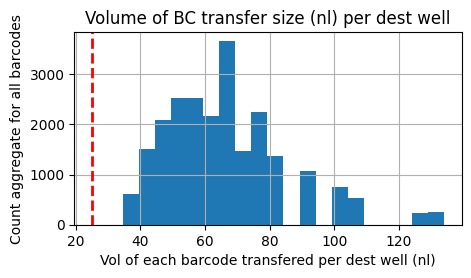

In [ ]:
# Check distribution of each barcode transfer volume per well
# Check that most barcodes are above the minimum volume of 25 nl for droplet in echo

fig, ax = plt.subplots(figsize=(5, 2.5))  # Set figure size
echo_df[echo_df['Source Plate Name']=='daisy_barcodes'].hist('Transfer Volume', bins=20, ax=ax)
ax.set_xlabel('Vol of each barcode transfered per dest well (nl)')
ax.set_ylabel('Count aggregate for all barcodes')
ax.set_title('Volume of BC transfer size (nl) per dest well')
ax.axvline(x=25, color='red', linestyle='--', linewidth=2)
plt.show()

In [ ]:
# Check that the total transfer volume for each barcode does not exceed 40 ul (Echo specs: 20 ul dead volume - 60 ul max).
# Alternatively, check that remaining volume for each barcodes is not below 20 ul, the dead volume
# because the usable volume for each well in echo 384-well plate is 20 - 65 ul, so we need set the working volume to be 20 - 60 ul!

bc_vol_used = echo_df[echo_df['Source Plate Name'] == 'daisy_barcodes'] \
    .groupby('Source Well') \
    .sum(numeric_only=True) \
    .sort_values('Transfer Volume', ascending=False) \
    * 1e-3 # convert to ul

max_bc_vol = 60 # Max volume that a well from 384 well plate can take 60 ul

bc_vol_used['remaining_bc_volume_after_transfer (ul)'] = bc_vol_used['Transfer Volume'].apply(lambda x: max_bc_vol - x) # calculate volume remaining for each bc after transfers

most_vol_bc_name = bc_vol_used.index[0]
most_vol_bc = int(bc_vol_used.iloc[0][["Transfer Volume"]])
most_vol_bc_remain_vol = int(bc_vol_used.iloc[0][["remaining_bc_volume_after_transfer (ul)"]])


if any(bc_vol_used['remaining_bc_volume_after_transfer (ul)'] < 20):
    # Print the rows where the remaining volume is less than 20
    print("Assertion failed. Please decrease dilution_factor variable or increase mimimum_bc_conc variable")    # default is 120 ng/ul. If need to increase, then try 130 or higher
    display(bc_vol_used[bc_vol_used['remaining_bc_volume_after_transfer (ul)'] < 20])
else:
    print(f"\n There is enough diluted barcode volume for all the barcode transfers. \n \
The most used barcode is {most_vol_bc_name} with {most_vol_bc} ul. \
Its remaining volume after all transfers is {most_vol_bc_remain_vol} ul.\
\n\n Instructions for barocde 384-well plate preparation: \n Take 10 ul of stock barcode and dilute with {(dilution_factor - 1)*10} ul of H20, BUT ONLY PIPETTE 60 ul INTO 384-echo PLATE FOR THE ECHO TRANSFERS! Do this dilution with multichannel for all 96 barcodes.")
    


 There is enough diluted barcode volume for all the barcode transfers. 
 The most used barcode is D3 with 33 ul. Its remaining volume after all transfers is 26 ul.

 Instructions for barocde 384-well plate preparation: 
 Take 10 ul of stock barcode and dilute with 80 ul of H20, BUT ONLY PIPETTE 60 ul INTO 384-echo PLATE FOR THE ECHO TRANSFERS! Do this dilution with multichannel for all 96 barcodes.


In [ ]:
# Export daisy chain transfer csv file into echo directory
write = False

name_daisy = 'daisy_barcodes'
sub_daisy = echo_df.groupby('Source Plate Name').get_group(name_daisy)    # get all the rows and values for daisy_barcodes
file_name = f'{date_time_str}_step1_{name_daisy}.csv'
output_file = os.path.join(echo_dir, file_name)

if write:
    wetlab_util_jq.export_to_csv(sub_daisy,output_file)
    #sub_daisy.head()

### 2. Water transfer

In [ ]:
# Generate dataframe for water fillup to be used for echo transfer instructions

# Make sure that the water_fillup volume from 6-well reservoir is not above 2500 ul
# Echo specs: 
# Number of wells: 6
# Maximum volume: 2500 uL. We set the max volume to be 2000 ul to be safe.
# Dead volume: 250 µL
# Usable volume: 2250 uL

print(f"Total water fillup volume needed: {int(echo_df[echo_df['Source Plate Name']=='water_fillup']['Transfer Volume'].sum() * 1e-3)} ul")

buff_vol = 0
buff_wells = wetlab_util_jq.generate_well_names('6w_plate') # generate names for 6-well plate = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']
buff_idx = 0

for index, row in echo_df.iterrows():
    
    if row['Source Plate Name'] == 'water_fillup':
        
        buff_vol += row['Transfer Volume']
        
        if buff_vol >= 2e6:   # set the max volume at 2000 ul instead of 2500 ul to be safe
            buff_idx += 1       # if it hits 2100 ul, then move to next index in buff_wells 
            buff_vol = 0

        echo_df.loc[index, 'Source Well'] = buff_wells[buff_idx]
        
echo_df[echo_df['Source Plate Name']=='water_fillup'].groupby('Source Well').sum(numeric_only=True)
#echo_df[echo_df['Source Plate Name']=='water_fillup']

Total water fillup volume needed: 6163 ul


,Transfer Volume
Source Well,
A1,1.999792e+06
A2,2.000643e+06
A3,2.000421e+06
B1,1.622553e+05


In [ ]:
# Export water fill transfer csv file into echo directory
write = False

name_water = 'water_fillup'
sub_water = echo_df.groupby('Source Plate Name').get_group(name_water)
file_name = f'{date_time_str}_step2_{name_water}.csv'
output_file = os.path.join(echo_dir, file_name)

if write: 
    wetlab_util_jq.export_to_csv(sub_water,output_file)

In [ ]:
## Use this if you need to fish out specific wells that failed

# barcode_df = echo_df[echo_df['Source Plate Name'] == 'barcode']
# barcode_df
# desired_wells = ["A1", "A5", "A7", "A9", "A11", "A13", "A15", "A17", "A19", "A21", "D15"]
# final_df = barcode_df[barcode_df['Source Well'].isin(desired_wells)]

# output_file = date_time_str + "_fixed_rowA_bc" + ".csv"
# final_df.to_csv(output_file, index=False)

### 3. GGA master mix transfer

In [ ]:
# Calculate total GGA mastermix volume 

gga_mm_per_reaction = 0.5 # (ul)
t4_ligase_buffer = 0.35 # (ul) 
bsai = 0.06  # (ul)
salt_t4 = 0.1   # (ul)
h20 = gga_mm_per_reaction - (t4_ligase_buffer + bsai + salt_t4)  # (ul)

# GGA mastermix volume for all 1536 plates
total_wells = total_no_of_wells * 1.25   # total number of well + 25% more to account for dead volumes

total_t4_ligase_buffer = t4_ligase_buffer * total_wells
total_bsai = bsai * total_wells
total_salt_t4 = salt_t4 * total_wells
total_h20 = h20 * total_wells
gga_mm_total = total_t4_ligase_buffer + total_bsai + total_salt_t4 + total_h20

#assert int(total_wells) == gga_mm_total
print(f'Total GGA mastermix volume needed: {int(gga_mm_total)} ul')

Total GGA mastermix volume needed: 4800 ul


In [ ]:
# Distribute GGA mastermix volume into 6-well echo reservoir

# Make sure that the GGA volume from 6-well reservoir is not above 2500 ul
# Echo specs: 
# Number of wells: 6
# Maximum volume: 2500 uL. We set the max volume to be 2000 ul to be safe.
# Dead volume: 250 µL
# Usable volume: 2250 uL

max_well_volume = 2000  # Max volume set to 2000 µL to be safe
buff_wells = wetlab_util_jq.generate_well_names('6w_plate') # generate names for 6-well plate

# Initialize variables
buff_vol = 0
buff_idx = 0
well_distribution = {well: 0 for well in buff_wells}

# Distribute the total volume among the wells
remaining_volume = gga_mm_total

while remaining_volume > 0:
    available_volume = min(remaining_volume, max_well_volume - well_distribution[buff_wells[buff_idx]])
    well_distribution[buff_wells[buff_idx]] += available_volume
    remaining_volume -= available_volume
    
    if well_distribution[buff_wells[buff_idx]] >= max_well_volume:
        buff_idx += 1
        if buff_idx >= len(buff_wells):
            break  # Stop if we've run out of wells

print("Distribution of total GGA mastermix among wells:")
for well, volume in well_distribution.items():
    print(f"Well {well}: {volume } µL")  # Convert back to µL for display

Distribution of total GGA mastermix among wells:
Well A1: 2000 µL
Well A2: 2000 µL
Well A3: 800.0 µL
Well B1: 0 µL
Well B2: 0 µL
Well B3: 0 µL


In [ ]:
# Generate GGA mastermix transfer instructions source plate and well to destination plate and well and volume
transfer_volume = gga_mm_per_reaction * 1000  # convert to (nl) of gga mix volume to transfer to each well in destination plate
dest_wells_1536 = wetlab_util_jq.generate_well_names('1536w_plate') # generate names for 1536-well plate

# Initialize the instructions list
echo_instructions = []
dest_counter = 0
dest_p_no = 1

# Loop over source wells based on the provided well distribution
for source_w, total_volume in well_distribution.items():
    total_volume = total_volume * 1000           # convert to nl
    remaining_volume = total_volume
    while remaining_volume > 250000:                 # Move to next item when the remaining volume reaches the 250 ul deadvolume
        if dest_counter == 1536:  # Move to next destination plate
            dest_counter = 0
            dest_p_no += 1
            
        if dest_p_no > no_dest_plates:  # Break if we've reached the maximum number of destination plates
            break
                
        dest_p = f"dest_1536_{dest_p_no:02d}"  # Destination plate name
        dest_w = dest_wells_1536[dest_counter]  # Destination well name

        echo_instructions.append([f"gga_mix", source_w, dest_p, dest_w, transfer_volume])
        remaining_volume -= transfer_volume
        dest_counter += 1

#echo_instructions
assert len(echo_instructions) == no_dest_plates*1536
print(f"Assertion passed. The number of {len(echo_instructions)} rows in echo instructions is correct.")

Assertion passed. The number of 7680 rows in echo instructions is correct.


In [ ]:
# Export GGA mastermix transfer csv file into echo directory
write = False

file_name = date_time_str + "_step3_gga_mix" + ".csv"
output_file = os.path.join(echo_dir, file_name)  # output directory and file_name

if write: 
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Source Plate Name",
                        "Source Well",
                        "Destination Plate Name"
                        ,"Destination Well",
                        "Transfer Volume"]) # Column name needs this format for Echo compatibility
        
        for instr in echo_instructions:
            writer.writerow(instr)
        print(f'GGA mix transfer echo csv file is saved as: \n{echo_dir}{file_name} \n')

GGA mix transfer echo csv file is saved as: 
/home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250520_echo_transfer/250520_step3_gga_mix.csv 



# Demultiplexing

### Setting Directories

In [ ]:
############################################################
# IMPORTANT: files to copy to reference folder: 
# 1. Reference 96 BC (96_bc_demux.csv) (csv format) 
# 2. Reference DNA design sequences (fasta format)
# 3. Reference 384 to 1536 wells from echo file (csv format) # to remove
#############################################################

In [3]:
'''
Define directories from user provided inputs
'''
# change this date for each experiment
seq_start_date = "250528"

sequencing_dir = f'{working_dir}{seq_start_date}_sequencing/'            # Folder processed sequencing data is output
os.makedirs(f'{sequencing_dir}',exist_ok=True)

raw_seq_data_dir = f'/projects/sequencing/MinION/{seq_start_date}_{library_name}/' # Folder where pod5 raw files are stored from sequencing

output_dir = f'/net/scratch/jq01/demuxing/{seq_start_date}_{library_name}_sequencing/' # Folder where large intermediate file is output in scratch
os.makedirs(f'{output_dir}',exist_ok=True)

reference_dir = f'{sequencing_dir}reference/' # Folder where barcode and reference files are stored
os.makedirs(f'{reference_dir}',exist_ok=True)

ref_96_bc = f'{reference_dir}24071396_three_BC_demux.csv' # Reference 96 barcodes from which daisy chained barcode combinations are constructed
ref_library = f'{reference_dir}20250414_NH20_subpool2.fasta'              # Reference library of your design
combo_bc = f'{echo_dir}250520_step1_daisy_barcodes.csv'         # The daisy chained combinations of 4 barcodes were used for this experiment
mapping_384_to_1536_wells = f'{echo_dir}250520_step0_culture_transfer.csv' # The transfer of 384-well cultured plates matched to 1536-well plates file

# # List of files to check
files_to_check = [ref_96_bc, ref_library]

# Check if the files exist and prompt if any file is missing
for file_path in files_to_check:
    if not os.path.exists(file_path):
        file_name = os.path.basename(file_path)
        print(f"File '{file_name}' does not exist.")
        print(f'Please copy the missing file into the {reference_dir} folder.\n')

In [4]:
'''
cmds folder: files with all the command lines for each job submission
submit folder: sh file for calling the command files
log folder: logs of submitted jobs
_0_basecalling_output: basecall sequencing files from pod5  
_1_fastq_output: filter reads based on quality score  
_2_bc_demuxing_output: demultiplex fastq for each daisy chain barcode combination
_3_consensus_output: generate consensus sequences from each demultiplexed files
'''

# Makes output directories (in home directory) and defines associated variables
wrk_dirs_list = ['cmds/','submit/','logs/','_2_bc_demuxing_output/', '_3_consensus_output/']

for wrk_dir in wrk_dirs_list:
    os.makedirs(f'{sequencing_dir}{wrk_dir}',exist_ok=True)
    dir_var_name = f'{wrk_dir.replace("/","")}_dir'

    # this is to make the dir_var_name so they can be referred to later on.
    all_vars = locals()
    all_vars[dir_var_name] = f'{sequencing_dir}{wrk_dir}'
    print(f'{sequencing_dir}{wrk_dir}')
    print(f'{dir_var_name} \n')
    
# Makes output directories (scratch) and defines associated variables
out_dirs_list = ['_0_basecalling_output/', '_1_fastq_output/']

for out_dir in out_dirs_list:
    os.makedirs(f'{output_dir}{out_dir}',exist_ok=True)
    dir_var_name = f'{out_dir.replace("/","")}_dir'
    
    all_vars = locals()
    all_vars[dir_var_name] = f'{output_dir}{out_dir}'
    print(f'{output_dir}{out_dir}')
    print(f'{dir_var_name} \n')

/home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250528_sequencing/cmds/
cmds_dir 

/home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250528_sequencing/submit/
submit_dir 

/home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250528_sequencing/logs/
logs_dir 

/home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250528_sequencing/_2_bc_demuxing_output/
_2_bc_demuxing_output_dir 

/home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250528_sequencing/_3_consensus_output/
_3_consensus_output_dir 

/net/scratch/jq01/demuxing/250528_NH20_subpool2_sequencing/_0_basecalling_output/
_0_basecalling_output_dir 

/net/scratch/jq01/demuxing/250528_NH20_subpool2_sequencing/_1_fastq_output/
_1_fastq_output_dir 



### 0. Basecalling

In [26]:
# Generate commands and sh submission files for basecalling using dorado.

gpu = 'h200' # choose GPU h200,l40 or a6000. l40 is much faster (~30 min to process), h200 is even faster (~3 min to process per job)

wetlab_util_jq.basecalling_job_submission(gpu, 
                                          cmds_dir, 
                                          logs_dir, 
                                          submit_dir, 
                                          raw_seq_data_dir, 
                                          _0_basecalling_output_dir)

submit this in the terminal: 
sbatch /home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250528_sequencing/submit/_0_basecalling_h200_gpu.sh


### 1. Filtering reads

In [27]:
# Generate sh submission file for quality filtering of basecalled reads (~ 30 min - 1h  to process)

# if you want default values, then comment out these values and erase variables in the command.
q_score=15        # quality score to filter on. Higher number filters on higher quality reads. (Default = 15)
min_length = 400  # Discard reads smaller than this number (bp).  (320 bp of barcodes + length of design) (Default = 400)
max_length = 1000 # Discard reads smaller than this number (bp).  (320 bp of barcodes + length of design) (Default = 1000)

wetlab_util_jq.reads_filtering_job_submission(logs_dir, 
                                              submit_dir, 
                                              _0_basecalling_output_dir, 
                                              _1_fastq_output_dir, 
                                              q_score, 
                                              min_length,
                                              max_length
                                              )

Using q_score: 15
Using min_length: 400 bp

Using max_length: 1000 bp

submit in the terminal: 
sbatch /home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250528_sequencing/submit/_1_filtering_reads_cpu.sh



### 2. Demultiplexing

#### Loading barcode files

In [5]:
# Load 96 reference barcodes
barcode_96 = wetlab_util_jq.load_reference_bc(ref_96_bc)
display(barcode_96.head())

# Load daisy chained barcodes combination used in the experiment
combo_barcodes = wetlab_util_jq.load_daisy_bc(combo_bc)
#display(combo_barcodes.head())

# Merge reference barcodes with daisy chained barcodes combination
merged_bc = pd.merge(combo_barcodes, barcode_96, left_index=True, right_on='bc_location_on_384_plate', how='left')
merged_bc.reset_index(drop=True, inplace=True)

# Creates dictionary key = 1536_dest_plate_and_well: value = barcode sequence
bc_dict = merged_bc.groupby('1536_dest_plate_and_well')['barcode_sequence'].apply(list).to_dict()

# check dictionary is correct
print(dict(list(bc_dict.items())[:5]))

,barcode_name,barcode_sequence,bc_location_on_96_plate,bc_location_on_384_plate
0,1_1,CATAAACTGGCGGAGTTGCACTGAT,A1,A1
1,1_2,GTGGGCCATCTTCCTGCGTATCAAA,A2,A3
2,1_3,GCCGAAATATGTTTAATGTGCCTCA,A3,A5
3,1_4,ACGATAAAACAACGGTAATCCGCCG,A4,A7
4,1_5,ATGTATGCGATCCCAGGTTTGACTT,A5,A9


{'1_A1': ['AGCCACCGACAACACCACATATATT', 'CCACACAAAAGATATCGTTCGGCTT', 'ATACAGCAGGGTGGAGTTTTCCCGC'], '1_A10': ['GTGCTTGCACTTACGACACAATTCC', 'GTTAGCTCGTGCGTTATCGGTTCTT', 'AGTTTTGGACTCAGCCCGAAGCCAT'], '1_A11': ['CGTATTTAAGCTGGGAAACGACCTG', 'GTTGACTGAGACTACGCGCGAGATC', 'GCATGTTAGCTGCCCGAGTGATTTC'], '1_A12': ['ATGTATGCGATCCCAGGTTTGACTT', 'TTCTGTTTAAGTGTGCCCTGGTTCA', 'TCCATGTTCCCGGAGTGCGAAAAGA'], '1_A13': ['ACGATAAAACAACGGTAATCCGCCG', 'GCGAGTGTGATCCTAGCTTACTGGT', 'GGTTACTCAAACGATTCTGCCTCGA']}


#### Generating commands for primer pairs

In [ ]:
############################################################
# IMPORTANT: 
# Structure of amplicons for 4 BC:
# primer pair 1/2: 2-3-4-dmx7-design-dmx0-1
# primer pair 3/4: 3-4-dmx7-design-dmx0-1-2
# primer pair 5/6: 4-dmx7-design-dmx0-1-2-3
# 
# Structure of amplicons for 3 BC:
# primer pair 1/2: 2-3-dmx7-design-dmx0-1
# primer pair 3/6: 3-dmx7-design-dmx0-1-2
#############################################################

In [29]:
############################################################
# Generation of demultiplexing commands for primer pairs that you used for the experiments 
############################################################
# For 4 BC: 
# choose any combination that you used for your experiment: primerpair1_2, primerpair3_4 and/or primerpair5_6
############################################################

# primer_pairs = ['primerpair1_2', 'primerpair3_4', 'primerpair5_6']
# wetlab_util_jq.demultiplexing_job_submission(primer_pairs,
#                                              bc_dict,
#                                              cmds_dir,
#                                              logs_dir,
#                                              submit_dir,
#                                              _1_fastq_output_dir,
#                                              _2_bc_demuxing_output_dir)

############################################################
# For 3 BC: (~ 30 to 60 min to process)
# choose any combination that you used for your experiment: primerpair1_2 and/or primerpair3_6
############################################################

primer_pairs = ['primerpair1_2', 'primerpair3_6']
wetlab_util_jq.demultiplexing_job_submission_3bc(primer_pairs,
                                             bc_dict,
                                             cmds_dir,
                                             logs_dir,
                                             submit_dir,
                                             _1_fastq_output_dir,
                                             _2_bc_demuxing_output_dir)

submit in the terminal for primerpair1_2: 
sbatch /home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250528_sequencing/submit/_2_demuxing_primerpair1_2_cpu.sh

submit in the terminal for primerpair3_6: 
sbatch /home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250528_sequencing/submit/_2_demuxing_primerpair3_6_cpu.sh



#### Combine all the demuxed fastq files

In [30]:
############################################################
# Combined all primer pair demuxed fastq files together
# This runs the function that 1) combines all the fastq files into a combined folder, 2) output the folder name. 
############################################################
# For 4 BC:
# primer_pairs = ['primerpair1_2', 'primerpair3_4', 'primerpair5_6']
# _2_combined_fastq_dir = wetlab_util_jq.combine_fastq_files(primer_pairs, _2_bc_demuxing_output_dir)

# For 3 BC:
primer_pairs = ['primerpair1_2', 'primerpair3_6']
_2_combined_fastq_dir = wetlab_util_jq.combine_fastq_files(primer_pairs, _2_bc_demuxing_output_dir)

100%|██████████| 7680/7680 [05:51<00:00, 21.85it/s]

Combined fastq files are saved in: 
/home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250528_sequencing/_2_bc_demuxing_output/combined_fastq/


#### Visualize plotting plates with detected designs with correct BC

In [6]:
_2_combined_fastq_dir = '/home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250528_sequencing/_2_bc_demuxing_output/combined_fastq/'

# List to hold the data
data_size = []

for well in glob.glob(f'{_2_combined_fastq_dir}*fastq'):
    # get each basename of each file
    bn = os.path.basename(well).replace('.fastq', '')

# #check individual primer pairs
# for well in glob.glob(f'{primer5_6_dir}*fastq'):
#     # get each basename of each file
#     bn = os.path.basename(well).replace('.fastq', '')

    # Open the file and count the number of reads
    with open(well, 'r') as file:
        # Count the number of lines and divide by 4 to get the number of reads
        num_reads = sum(1 for line in file) / 4
    
    # Determine design_detected based on the number of reads
    design_detected = 1 if num_reads > 150 else 0
    
    # Append the result to the list
    data_size.append({'Name': bn, 'design_detected': design_detected, 'num_reads':int(num_reads)})

# Convert the list to a pandas DataFrame
plate_detection = pd.DataFrame(data_size)
plate_detection.head()

,Name,design_detected,num_reads
0,5_Z19,1,628
1,5_T3,1,962
2,2_K43,1,1187
3,5_G37,1,3308
4,2_N40,1,1997


In [32]:
plate_detection['Plate'] = plate_detection['Name'].str.split('_').str[0]

# Sum 'design_detected' for each plate
design_counts = plate_detection.groupby('Plate')['design_detected'].sum()

# Display the counts for each plate
print(design_counts)

Plate
1    1530
2    1526
3    1524
4    1423
5    1525
Name: design_detected, dtype: int64


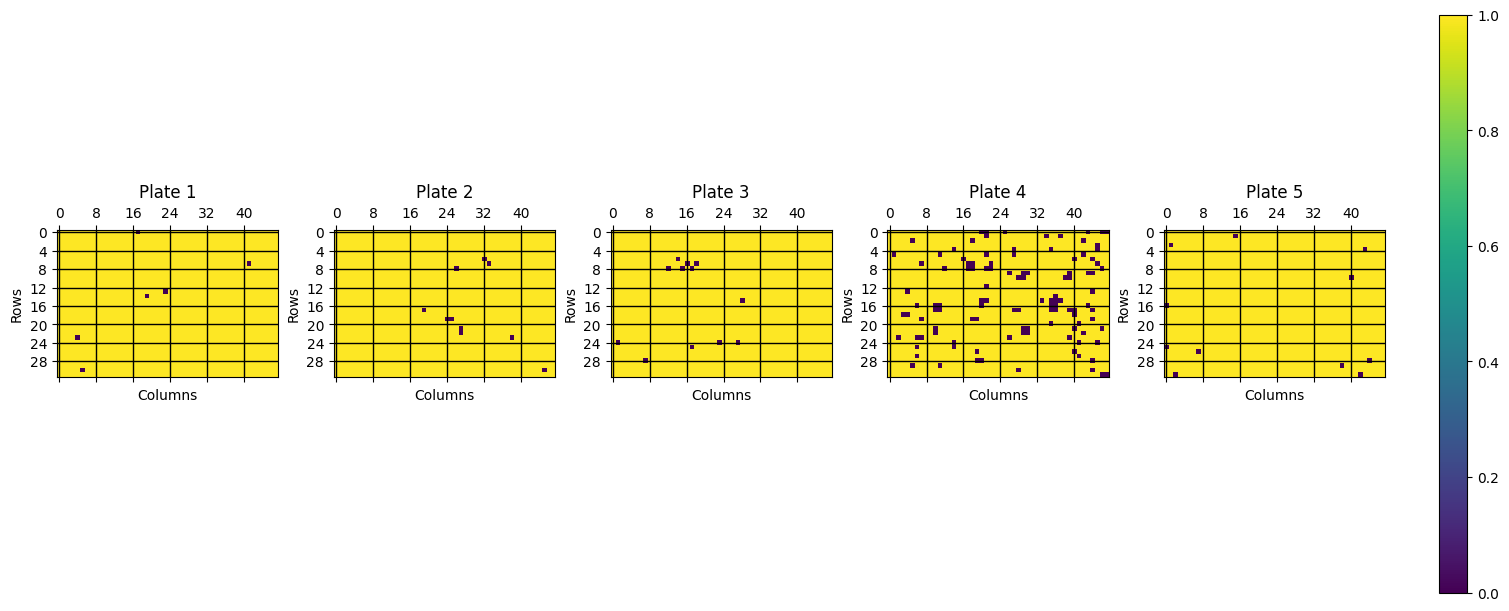

In [33]:
# Plotting plate mapping with wells that had correct demuxed barcode reads

# Parse the plate number and well position
plate_detection['Plate'] = plate_detection['Name'].apply(lambda x: x.split('_')[0])
plate_detection['Well'] = plate_detection['Name'].apply(lambda x: x.split('_')[1])

# Mapping function for wells
def well_to_indices(well):
    row_part = ''.join(filter(str.isalpha, well))
    col_part = ''.join(filter(str.isdigit, well))
    
    # Mapping rows with double letters (handle up to ZZ for simplification)
    row = (ord(row_part[-1]) - ord('A')) + (26 if len(row_part) == 2 else 0)
    
    # Convert column from 1-based to 0-based
    col = int(col_part) - 1
    return row, col

# Create empty grids for each plate
plate_grids = {plate: np.zeros((32, 48), dtype=int) for plate in sorted(plate_detection['Plate'].unique())}

# Fill the grids
for _, row in plate_detection.iterrows():
    plate = row['Plate']
    r, c = well_to_indices(row['Well'])
    plate_grids[plate][r, c] = row['design_detected']

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=len(plate_grids), figsize=(15, 6), constrained_layout=True)
if len(plate_grids) == 1:  # Ensure axes is iterable
    axes = [axes]

for ax, (plate, grid) in zip(axes, plate_grids.items()):
    cax = ax.matshow(grid, cmap='viridis', vmin=0, vmax=1)
    ax.set_title(f'Plate {plate}')
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.set_xticks(range(0, 48, 8))
    ax.set_yticks(range(0, 32, 4))
    ax.grid(True, which='both', color='k', linestyle='-', linewidth=1)

# Add colorbar and layout
fig.colorbar(cax, ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
#plt.normal_layout()
plt.show()

### 3. Alignement to reference and consensus sequence generation

In [34]:
# Generate sh submission file to run the alignment and consensus sequence generation commands (~ 2 minutes)

minimum_depth = 150 # minimum reads depth required to make a consensus call. Default is 150

wetlab_util_jq.consensus_sequence_job_submission(cmds_dir,
                                                 logs_dir,
                                                 submit_dir,
                                                 _3_consensus_output_dir,
                                                 _2_combined_fastq_dir,
                                                 ref_library,
                                                 minimum_depth)

submit in the terminal: 
sbatch /home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250528_sequencing/submit/_3_consensus_sequence_cpu.sh



### 4. Re-arraying DMXed clones into plates for glycerol stock

In [6]:
# import fasta files generated from consensus sequence generation into dataframe 
def parse_fasta_biopython(fasta_filename):
    sequences = {}
    for record in SeqIO.parse(fasta_filename, "fasta"):
        sequences[record.id] = str(record.seq)
    return sequences

def consensus_df(folder_name):
    data = []
    # All sequence from barcoded combo
    for well in glob.glob(f'{folder_name}*fa'):
        bn = os.path.basename(well).replace('.fa', '')
        sequences = parse_fasta_biopython(well)
        # Append each sequence information to the DataFrame
        data.extend([{
            "1536_well_name": bn,
            "design_name": design_name,
            "sequence": sequence,
            "length": len(sequence)
        } for design_name, sequence in sequences.items()])
    df_consensus = pd.DataFrame(data)
    return df_consensus

# Load reference sequence of designs as dataframe
sequences = parse_fasta_biopython(ref_library)
data = [{   
            "design_name": design_name,
            "sequence": sequence,
            "length": len(sequence)
        } for design_name, sequence in sequences.items()]
df_ref_lib = pd.DataFrame(data)

## Load demuxed consensus sequences as dataframe
all_primers_cons = consensus_df(f'{_3_consensus_output_dir}/')

# Merge and compare dmx consensus sequences with reference library sequences
all_primers_cons = all_primers_cons.merge(df_ref_lib, on='design_name', suffixes=('', '_ref'))
all_primers_cons['correct_sequence'] = all_primers_cons.apply(lambda row: row['sequence'] == row['sequence_ref'], axis=1)

In [7]:
# From echo culture transfer file, import wells matching  384-well to 1536-well plates  
mapping_384to1536 = pd.read_csv(mapping_384_to_1536_wells, sep=',')
mapping_384to1536.rename(columns={
    'Source Plate Name': 'source_plate', 
    'Source Well': "source_well",
    'Destination Plate Name': '1536_dest_plate', 
    'Destination Well': '1536_well',
    'Transfer Volume': 'transfer_volume'}, inplace=True)
mapping_384to1536['1536_plate_and_well'] = mapping_384to1536['1536_dest_plate'].str[-1] + "_" + mapping_384to1536['1536_well']

In [8]:
# Obtain final list of wells that each have a unique and perfect design

# Drop wells that have multiple sequences in them. (keep=False means it drops all duplicates)
unique_design_per_well = all_primers_cons.drop_duplicates(subset="1536_well_name", keep=False)

# Keep wells that have perfect design compared to reference library
unique_design_per_well_correct = unique_design_per_well[unique_design_per_well['correct_sequence'] == True]

# Keep only one well (e.g. the first in the list) that has a perfect design in it
unique_set_correct = unique_design_per_well_correct.drop_duplicates(subset='design_name', keep='first')

# Sort by plate name
unique_set_correct = unique_set_correct.sort_values(by='1536_well_name', ascending=True).reset_index(drop=True)

# Matching perfect design list from demuxing output to the 384-well template plate list
dmx_clones = mapping_384to1536.merge(unique_set_correct, left_on='1536_plate_and_well', right_on='1536_well_name')

print(f'Perfect unique designs that to be re-arrayed into glycerol plates: {len(unique_set_correct)}')
dmx_clones

Perfect unique designs that to be re-arrayed into glycerol plates: 1073


,source_plate,source_well,1536_dest_plate,1536_well,transfer_volume,1536_plate_and_well,1536_well_name,design_name,sequence,length,sequence_ref,length_ref,correct_sequence
0,source_384_01,A16,dest_1536_01,A16,2000.0,1_A16,1_A16,NH2_0129__C10__20250415_chip_.2__1729_c4_glu_square_33_2_pred.m4_pre-selected_rotamer_5_quadratic_AEA_33_pose_H__E_3_-60_-40_24747_freq_0.0267637_33_symmetric_82_mpnn_8_unrelaxed_multimer_v3_model_4_seed_000_model_idx_1,GTGGAAGAAGTGCGCGCGGAATTACGTGCGGTGGAATTTCCGCCATCTGAAGCGGCTGCGCGTTTGCGTCGTGCCGTGGATCTGGTTTTGGATACCTGGACCGCAGCGATTGCAGCGGCGGAAGCGGCAGGTAATGCAGCGTTAGCACGTGAAGCGTATTTTGCGCTGCTGAACGCCCTGCTGCAGGTGATTGTGTTAGGTCTGCTGGCAGGCGAAGTGGAAGGCGCACTGCGTCTGGCCGAAGCATTACGTCGTTTACTGCCGCGTATTGTGGCGGCGGCAATTGCGGCCGAAAAGGCGGCG,303,GTGGAAGAAGTGCGCGCGGAATTACGTGCGGTGGAATTTCCGCCATCTGAAGCGGCTGCGCGTTTGCGTCGTGCCGTGGATCTGGTTTTGGATACCTGGACCGCAGCGATTGCAGCGGCGGAAGCGGCAGGTAATGCAGCGTTAGCACGTGAAGCGTATTTTGCGCTGCTGAACGCCCTGCTGCAGGTGATTGTGTTAGGTCTGCTGGCAGGCGAAGTGGAAGGCGCACTGCGTCTGGCCGAAGCATTACGTCGTTTACTGCCGCGTATTGTGGCGGCGGCAATTGCGGCCGAAAAGGCGGCG,303,True
1,source_384_01,A21,dest_1536_01,A21,2000.0,1_A21,1_A21,NH2_0124__C5__20250415_chip_.2__1724_c4_glu_square_29_73_pred.m4_pre-selected_rotamer_17_quadratic_AEA_29_pose_H__E_3_-60_-40_24745_freq_0.0432937_29_symmetric_0_mpnn_16_unrelaxed_multimer_v3_model_4_seed_000_model_idx_1,GGCGTGGTGACCGAAGAAGATAAAGAATTTGCGAAGAAATTTGAAGAGAAAGTGTATGAATTTCTGACCAGCATTATTGAAGCGGGCGGCACCATTACCGAAATTATTAGCGCGATTAACCTGGCGGTGAACCTGGCGTTACTGCTGGGCGAAGATCCGGAAAAGCGCGAAAGCCTGCTGCCGGCGCTGCTGAAAGGCCTGGTGGAAGCGATTGAACGCGCGATCGAAGAATGCCCGATGACGGAAGAAACCAAAGAAACCCTGCGCAAAATTGCGGAACTGATTAAACTGGTGCTGGAGAAA,303,GGCGTGGTGACCGAAGAAGATAAAGAATTTGCGAAGAAATTTGAAGAGAAAGTGTATGAATTTCTGACCAGCATTATTGAAGCGGGCGGCACCATTACCGAAATTATTAGCGCGATTAACCTGGCGGTGAACCTGGCGTTACTGCTGGGCGAAGATCCGGAAAAGCGCGAAAGCCTGCTGCCGGCGCTGCTGAAAGGCCTGGTGGAAGCGATTGAACGCGCGATCGAAGAATGCCCGATGACGGAAGAAACCAAAGAAACCCTGCGCAAAATTGCGGAACTGATTAAACTGGTGCTGGAGAAA,303,True
2,source_384_01,A24,dest_1536_01,A24,2000.0,1_A24,1_A24,NH2_0332__D9__20250415_chip_.4__1935_d2_asp_tetrahedral_0_pos_8_pred.pre-selected_pre-folded_8_m4_rotamer_0_pos_8_cubic_pose_H__D_3_-60_-40_8247_freq_0.0787197_symmetric_22_mpnn_12_unrelaxed_multimer_v3_model_4_seed_000_model_idx_1,ATGATGGAAGTGGCGGCGTTTATGGATTTTCTGGTGACCGTGCTGAACGCGCTGATGGCGAGCGGTAAATGCACCCCGCTGATTCGTGCGACCACCAAAGAAGCGTTAGCGGCGCTGATCGAAGATGGCACCCGTGAAACCGCGATTGAAGCGGTGGCACGTGTGATGGCCGCGTATGAAGAAGCGGGTCTGGAAGATGCGGCGGAAGCGCTTCGCAACTTTGCGGTGCTGTTGGGCCTGGATCGTGAAGAAATCGAAGCGGCACGCGCGGAAATTGCAGCAAAACGTGCGGCCGCAGCAGCA,303,ATGATGGAAGTGGCGGCGTTTATGGATTTTCTGGTGACCGTGCTGAACGCGCTGATGGCGAGCGGTAAATGCACCCCGCTGATTCGTGCGACCACCAAAGAAGCGTTAGCGGCGCTGATCGAAGATGGCACCCGTGAAACCGCGATTGAAGCGGTGGCACGTGTGATGGCCGCGTATGAAGAAGCGGGTCTGGAAGATGCGGCGGAAGCGCTTCGCAACTTTGCGGTGCTGTTGGGCCTGGATCGTGAAGAAATCGAAGCGGCACGCGCGGAAATTGCAGCAAAACGTGCGGCCGCAGCAGCA,303,True
3,source_384_01,B22,dest_1536_01,A46,2000.0,1_A46,1_A46,NH1_0730__E11__20250415_chip_.8__947_c3_asp_trigonal_21_3_21_pred.pre-selected_pre-folded_21_m1_rotamer_3_quadratic_ADA_21_pose_H__D_3_-60_-40_8244_freq_0.49051_21_symmetric_84_mpnn_10_model_1_ptm_seed_0_unrelaxed_model_idx_1,ATGGGCTTAAGTCAGGCGGCGTTGGCGGCGCTTGTTGCAGCGATTGTGGCAGCGTTAGCATTAGGCCTGGCGGAGTTAATGGCGGAATTAGGTGCGGATGCTGCGACCGCGGTGGATCTGGTGGAACTGCTGGTTGAACTGGTGAGCCGCGATGCGGAGAAAGTTACCGGCGTTCGCCGCGAAGATTTACGCGCAGTGCTGGCGCCGTTATTAGAAGGTTTAGCTGCAGCACCGCCAGCAGCATTTCCAGCACTGGCACGTGCTGCGTTTCGTGCAGCGCTTGCGCGTTATCAGGCACTGCGC,303,ATGGGCTTAAGTCAGGCGGCGTTGGCGGCGCTTGTTGCAGCGATTGTGGCAGCGTTAGCATTAGGCCTGGCGGAGTTAATGGCGGAATTAGGTGCGGATGCTGCGACCGCGGTGGATCTGGTGGAACTGCTGGTTGAACTGGTGAGCCGCGATGCGGAGAAAGTTACCGGCGTTCGCCGCGAAGATTTACGCGCAGTGCTGGCGCCGTTATTAGAAGGTTTAGCTGCAGCACCGCCAGCAGCATTTCCAGCACTGGCACGTGCTGCGTTTCGTGCAGCGCTTGCGCGTTATCAGGCACTGCGC,303,True
4,source_384_01,B23,dest_1536_01,A47,2000.0,1_A47,1_A47,NH2_0101__A6__20250415_chip_.2__1701_c4_glu_square_29_50_pred.m4_pre-selected_rotamer_9_cubic_AEA_29_pose_H__E_3_-60_-40_24734_freq_0.0503943_29_symmetric_90_mpnn_8_

In [14]:
# Generate instructions source plate and well to destination plate and well and volume

# Generate 384-well names
dest_wells_384 = wetlab_util_jq.generate_well_names('384w_plate')

# Initialize variables
volume = 1000.0  # nanoliters
echo_instructions = []
dest_counter = 0  # To keep track of destination well
dest_p_no = 1     # To keep track of destination plate number

for i, row in dmx_clones.iterrows():
    if dest_counter == 384:  # Reset for new plate after 384 wells
        dest_counter = 0
        dest_p_no += 1

    # Current destination plate and well
    dest_p = f"dest_384_plate_{dest_p_no:02d}"
    dest_w = dest_wells_384[dest_counter]
    
    echo_instructions.append([row["source_plate"], row["source_well"], dest_p, dest_w, volume])  # Append the instruction with design name
    
    # Increment the destination counter
    dest_counter += 1

print(f"Generated {len(echo_instructions)} transfers across {dest_p_no} glycerol destination plates (384-well plates).")

Generated 1073 transfers across 3 glycerol destination plates (384-well plates).


In [ ]:
# Export dmx clone reaaray transfer csv file into echo directory
date_time_str = date.today().strftime('%Y%m%d')[2:]
write_echo_file = False
write_all_info = True

file_name_echo_transfer = f'{date_time_str}_step4_demuxed_clone_rearray.csv'
file_name_ALL_INFO = f'{date_time_str}_step4_demuxed_clone_rearray_ALL_INFO.csv'

output_file_echo_transfer = os.path.join(echo_dir, file_name_echo_transfer)  # output directory and file_name
output_file_ALL_INFO = os.path.join(echo_dir, file_name_ALL_INFO)  # output directory and file_name

if write_echo_file:
    # Export only the transfer instructions without design name and sequence
    with open(output_file_echo_transfer, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Source Plate Name",
                        "Source Well",
                        "Destination Plate Name",
                        "Destination Well",
                        "Transfer Volume"]) # Column name needs this format for Echo compatibility
        for instr in echo_instructions:
            writer.writerow(instr[:5])  # Write only the first 5 columns
        print(f'Re-arraying transfer echo csv file is saved as: \n{echo_dir}{file_name_echo_transfer} \n')

if write_all_info:
    # Export all information including design name and sequence
    echo_df = pd.DataFrame(echo_instructions, columns=[
    "source_plate",
    "source_well",
    "dest_plate",
    "dest_well",
    "volume_nl"
    ])
    echo_df = echo_df[['source_plate', 'source_well', 'dest_plate', 'dest_well']]

    echo_df_all_info = pd.merge(dmx_clones, echo_df, on=["source_plate", "source_well"], how="inner")
    echo_df_all_info = echo_df_all_info[['source_plate','source_well', '1536_dest_plate', '1536_well', 'design_name', 'sequence','length','correct_sequence', 'dest_plate', 'dest_well']]
    echo_df_all_info['384_glycerol_plate'] = echo_df_all_info['dest_plate'].str[-1] + "_" + echo_df_all_info['dest_well']

    columns_order = ['source_plate', 'source_well', '1536_dest_plate', '1536_well' , 'dest_plate', 'dest_well', '384_glycerol_plate', 'design_name', 'sequence', 'length', 'correct_sequence']
    echo_df_all_info = echo_df_all_info[columns_order]
    echo_df_all_info.to_csv(output_file_ALL_INFO, index=False)
    
    print(f'Re-arraying csv file with all info is saved as: \n{echo_dir}{file_name_ALL_INFO} \n')


Re-arraying transfer echo csv file is saved as: 
/home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250520_echo_transfer/250601_step4_demuxed_clone_rearray.csv 

Re-arraying csv file with all info is saved as: 
/home/jq01/wetlab/sequencing/nanopore/250520_NH20_subpool2/250520_echo_transfer/250601_step4_demuxed_clone_rearray_ALL_INFO.csv 



### 5. Re-arraying from 384-well glycerol stock to 96-well protein purification plates 

In [13]:
# here the dataframe:
# culture plate: source_plate: source_384_01 
# demuxed plate: 1536_dest_plate: dest_1536_01
# final arrayed plate (glycerol plate): dest_plate: dest_384_plate_01 and dest_well: A1
# 384_glycerol_plate is the combination of dest_plate and dest_well
# matched with sequences

In [ ]:
# Mapping of our custom 384_glycerol_plate to 96 well protein purification plates
# 384 well to 96 well format. 
# A1 -> A1, A3 -> A2, A5 -> A3, A7 -> A4 ..
# A2 -> B1, A4 -> B2, A6 -> B3, A8 -> B4 ..
# B1 -> C1, B3 -> C2, B5 -> C3, B7 -> C4 ..
# B2 -> D1, B4 -> D2, B6 -> D3, B8 -> D4 ..

def map_384_to_96(total_wells_num):
    """Map 384-well plate wells into multiple 96-well plates according to the specified pattern."""
    # Generate well names for a 384-well plate (16 rows x 24 columns)
    plate_384_wells = wetlab_util_jq.generate_well_names('384w_plate')
    
    # Generate well names for a single 96-well plate (8 rows x 12 columns)
    plate_96_wells = wetlab_util_jq.generate_well_names('96w_plate')

    mapping = []
    plate_index = 1
    well_counter = 0
    src_plate_index = 1

    while well_counter < total_wells_num:
        for row in range(16):
            for col in range(0, 24, 2):
                if well_counter >= total_wells_num:
                    break
                src_well = f"{src_plate_index}_{plate_384_wells[row * 24 + col]}"
                dest_well = f"{chr(65 + ((well_counter // 12) % 8))}{(well_counter % 12) + 1}"
                mapping.append((src_well, f"{plate_index}_{dest_well}"))

                well_counter += 1
                if well_counter % 96 == 0:
                    plate_index += 1

            if well_counter >= total_wells_num:
                break

            for col in range(1, 24, 2):
                if well_counter >= total_wells_num:
                    break
                src_well = f"{src_plate_index}_{plate_384_wells[row * 24 + col]}"
                dest_well = f"{chr(65 + ((well_counter // 12) % 8))}{(well_counter % 12) + 1}"
                mapping.append((src_well, f"{plate_index}_{dest_well}"))

                well_counter += 1
                if well_counter % 96 == 0:
                    plate_index += 1

            if (row + 1) % 16 == 0 and well_counter < total_wells_num:
                src_plate_index += 1

    num_384_well_plates = (total_wells_num + 383) // 384
    num_96_well_plates = (total_wells_num + 95) // 96

    print(f"Total number of 384-well plates needed: {num_384_well_plates}")
    print(f"Total number of 96-well plates needed: {num_96_well_plates}")

    return mapping

In [ ]:
# Example usage
total_wells_num = 1152  # Set the total number of wells to map
well_mapping = map_384_to_96(total_wells_num)

# Convert mapping to a DataFrame for better visualization and save to a file
df_mapping = pd.DataFrame(well_mapping, columns=['384_glycerol_plate', '96_purified_proteins_plate'])

Total number of 384-well plates needed: 3
Total number of 96-well plates needed: 12


In [ ]:
final_rearrayed_384to96_df = pd.merge(df_mapping, echo_df_all_info, on=["384_glycerol_plate"], how="inner")
final_rearrayed_384to96_df.head()

,384_glycerol_plate,96_purified_proteins_plate,source_plate,source_well,1536_dest_plate,1536_well,dest_plate,dest_well,design_name,sequence,length,correct_sequence
0,1_A1,1_A1,source_384_01,A3,dest_1536_01,A3,dest_384_plate_01,A1,subpool3_sequence_549,ATGGAGAAACTGAAGGTCGTGAAAACCGTGACGTTTGATGGTAAAGAATATAAGTTCGAAGCGGAGCTGGAACTGAACAGCAGCAGCCAGACGGTGACCGTTACCGATAAAGAAAGCAACGTTACCCTGAAAGTGACCTTCGCGAACATTAGCGAAGAAGGCCTGGAAGAAAAGAGCGCGACCCTGACCATTGATGGCAAAACCTATGAACTGGAAGTGGAAAGCATCAGCTACGAAAACGGCACCTATTATGTGACCAACAAACTGAAA,270,True
1,1_A3,1_A2,source_384_01,A6,dest_1536_01,A6,dest_384_plate_01,A3,subpool3_sequence_615,ATGACCGTTACCAAAGTGTTTAAACGCGGCGATACCGAAGCGAGCGCGACCGTTTCTGTGGCGGATAACACCTGGACCACCATCACCGTGACCTATGAAATTGATGGCAAAACCTACGAATTTACCCTGACCGTGAAAGTGGATAAAGCGAACGGCCTGGTGTATGAACAGCGCGTGCCGGGCAAAACGTACGAAGTGACGTATGAAGTGAACGGTCAGAGCTATCCGCTGGCGATTACCCCGGAAGGCGATTGGTATCGTGCGAGCTTTCCGAGCTCGGCGACCAACGTGACCATTACCAACACCGAA,309,True
2,1_A5,1_A3,source_384_01,A14,dest_1536_01,A14,dest_384_plate_01,A5,subpool3_sequence_74,GCGACCTATAAATTCAAGAAAACCTTCGATCACGATGGTAAAACCCTGACGTTTGAATTTAGCGTGACCACCACCGCGAACACCCAGACCTTTACCAAAACCGTGAGCACCACCCTGGATGGCAAAACCTATAGCCTGACCCTGAAATTTACCCTGAACGTGGCGACCAAAACGGCGGATGAAGAACCGGTGACCCTGTATGTGAACGGCAAACCGGTTGCGGATTATAAACAGGCGAGCCAGAGCTATAGCAACGGCGTGTATAACATTACCAACGAAAAGGTGGAA,288,True
3,1_A7,1_A4,source_384_01,A18,dest_1536_01,A18,dest_384_plate_01,A7,subpool3_sequence_555,ATGACCGTAACCGTTAACAAAACGTTTGAAACCGAAGCGCCGGTGGATGTGAAAGTTACCATTACCGTGGAAGCCGAAGGCAAAACCAAAACCGAAACCCTGACCTATGAAAACCTGAAACCGGGCGATAAGAAAGAATGGACCCTGACCCTGGAAGCACCGGAAGCGGGCGAAGTTACGGTGAACGAAACCGTGACCGTGAAAGCGAAAGAAGGTAAAGTTCGCGCGACCGTTACCGTTGAAGCCCAGGGCATTACGAAAACCGCCGAAGCCGTGGCGGATAAAGAAGAAGTGACCCTGACGGTGACGCTGACCTTTGAAGCGACCGAAGAAGAGGTGACCGTCAACGTGACCAACAAAGTGGAGAAAGTGGAAGAA,378,True
4,1_A9,1_A5,source_384_01,B14,dest_1536_01,A38,dest_384_plate_01,A9,subpool3_sequence_424,ATGACCCTGAACGTGACGAAAACCTTCACCTACAAATATGGCACCCAGGAAAAGAAAATTACCAAGAACTTTACCATTGCGGCGGATGATGGCAAAACCTATTCCAAAACCCTGAGCTATAGCGAAACCTTGACCTTTACCGATCCGGAAACCGGTAAGAAATATAGCTACGATGTGAACGTTACCTATACCGTGACGGTGAAACGCGAAGGCGATACCCTGACCGTGACCGAAACCACCAGCACCAACTTTGATAGTCTGACCATTACCGATACTGAAACCGGCCTGAGCGCGACCGCGGCAGCGAATAGCAACAGCGTTAGTTTAACCGTGCCGGCGGATACCACCGCGGTGAACATTAACAACGTGAAAACGCTGAAAGAT,384,True
